In [1]:
%load_ext autoreload
%autoreload 2
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, pickle, pyemma as py, sys, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
%matplotlib inline
from temp_tf_load import *
sys.path.append('../')
from hde import HDE, analysis
lag_time = 10
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# load pairwise distances and dihedral angles computed from simulation trajectory
pairwise_dis = np.load('/home/kengyangyao/data/HDE_data/alanine_dipeptide/pairwise_dis.npy')
dihedrals = np.load('/home/kengyangyao/data/HDE_data/alanine_dipeptide/dihedrals.npy')
scaler = pre.MinMaxScaler(feature_range=(-1, 1))
pairwise_dis_s = scaler.fit_transform(pairwise_dis)
cossin_dihedrals = np.concatenate([np.cos(dihedrals), np.sin(dihedrals)], axis=1)

## kernel tICA

In [3]:
from temp_ktica import *

In [4]:
# find landmarks, this may take a while.  We use 5000 landmarks in our paper, but it 
# takes very long time to do clustering, so here we use 2000 instead
from sklearn.cluster import KMeans
n_landmarks = 2000
kmeans = KMeans(init='k-means++', n_clusters=n_landmarks, n_init=10)
kmeans.fit(pairwise_dis_s[::50])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2000, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
# take longer than previous cell
temp_dataset = pairwise_dis_s
temp_landmarks = kmeans.cluster_centers_
for sigma in [2.0]:    #  # best sigma for scaled pairwise distances with 5000 landmarks
    ktica = Kernel_tica(3, lag_time=10, gamma=1./(2 * sigma ** 2), n_components_nystroem=len(temp_landmarks), 
                       landmarks = temp_landmarks)
    ktica_coords = ktica.fit_transform([temp_dataset])[0]
    print(sigma, ktica._tica.timescales[:5])
    ktica_timescales = ktica._tica.timescales[:3]

using landmarks


100%|██████████| 30/30 [03:45<00:00,  7.13s/it]                       


2.0 [663.30461311  36.73776355  16.85202968   4.13034719   4.01966179]


In [6]:
# these are precomputed ktica coordinates and timescales
# ktica_coords = np.load('/home/kengyangyao/data/hde_paper_results/adp_ktica_coords.npy')
# ktica_timescales = np.load('/home/kengyangyao/data/hde_paper_results/adp_ktica_timescales.npy')

## HDE

In [20]:
skip = 1
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
hde = HDE(45, n_components=3, lag_time=lag_time // skip, dropout_rate=0, batch_size=50000, n_epochs=200, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])

In [21]:
# hde.r_degree = 10    # pre-training, to speed up discovery of first few slowest modes
# hde.batch_size = 200000
# hde.n_epochs = 50
# hde.fit(pairwise_dis_s)
# hde._recompile = True
# hde.r_degree = 5
# hde.fit(pairwise_dis_s)
# hde.batch_size = 500000
# hde._recompile = True
# hde.r_degree = 2
# hde.n_epochs = 100
# hde.fit(pairwise_dis_s)

In [22]:
hde.r_degree = 2
hde.n_epochs = 100
hde.fit(pairwise_dis_s)

Train on 799992 samples, validate on 199998 samples
Epoch 1/100
799992/799992 [==============================] - 2s 3us/step - loss: -2.2296 - val_loss: -2.4945
Epoch 2/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.5210 - val_loss: -2.5382
Epoch 3/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.5420 - val_loss: -2.5472
Epoch 4/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.5479 - val_loss: -2.5506
Epoch 5/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.5504 - val_loss: -2.5522
Epoch 6/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.5518 - val_loss: -2.5533
Epoch 7/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.5526 - val_loss: -2.5539
Epoch 8/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.5531 - val_loss: -2.5543
Epoch 9/100
799992/799992 [==============================] - 1s 2us/step - l

799992/799992 [==============================] - 1s 1us/step - loss: -2.8726 - val_loss: -2.8757
Epoch 76/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.8698 - val_loss: -2.8796
Epoch 77/100
799992/799992 [==============================] - 1s 1us/step - loss: -2.8712 - val_loss: -2.8762
Epoch 78/100
799992/799992 [==============================] - 1s 1us/step - loss: -2.8731 - val_loss: -2.8766
Epoch 79/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.8733 - val_loss: -2.8725
Epoch 80/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.8739 - val_loss: -2.8769
Epoch 81/100
799992/799992 [==============================] - 1s 1us/step - loss: -2.8713 - val_loss: -2.8751
Epoch 82/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.8748 - val_loss: -2.8720
Epoch 83/100
799992/799992 [==============================] - 1s 2us/step - loss: -2.8757 - val_loss: -2.8703
Epoch 84/100
799992/799

HDE(activation=None, batch_normalization=True, batch_size=50000,
  callbacks=[<keras.callbacks.EarlyStopping object at 0x7f674c42a278>],
  dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=45,
  l2_regularization=0.0, lag_time=10, latent_space_noise=0,
  learning_rate=0.01, n_components=3, n_epochs=100, validation_split=0.2,
  verbose=True)

In [23]:
hde_coords = hde.transform(pairwise_dis_s)
hde_timescales = hde.timescales_
print(hde_timescales)

[796.48540322  36.66098692  17.30255634]


## MSM

In [11]:
tica = py.coordinates.tica(pairwise_dis_s, lag=lag_time, var_cutoff=0.99)
tica_coords = np.concatenate(tica.get_output())

In [12]:
cluster = py.coordinates.cluster_kmeans(tica_coords, k=200, n_jobs=1, max_iter=50)

100%|██████████| 50/50 [00:27<00:00, 17.87s/it]                  


In [13]:
msm = py.msm.bayesian_markov_model(cluster.dtrajs, lag=lag_time)
print("Fraction of states used = {:.2f}".format(msm.active_state_fraction))
print("Fraction of counts used = {:.2f}".format(msm.active_count_fraction))

100%|██████████| 100/100 [00:05<00:00, 17.38it/s]               

Fraction of states used = 1.00
Fraction of counts used = 1.00


In [14]:
eigvec = msm.eigenvectors_right()
dtrajs = np.concatenate(cluster.dtrajs)
msm_coords = eigvec[dtrajs,1:6]
msm_timescales = msm.sample_mean('timescales', k=20)
print(msm_timescales[:4])

[808.75677972  36.57383181  16.69828449   3.6630034 ]


## compare results

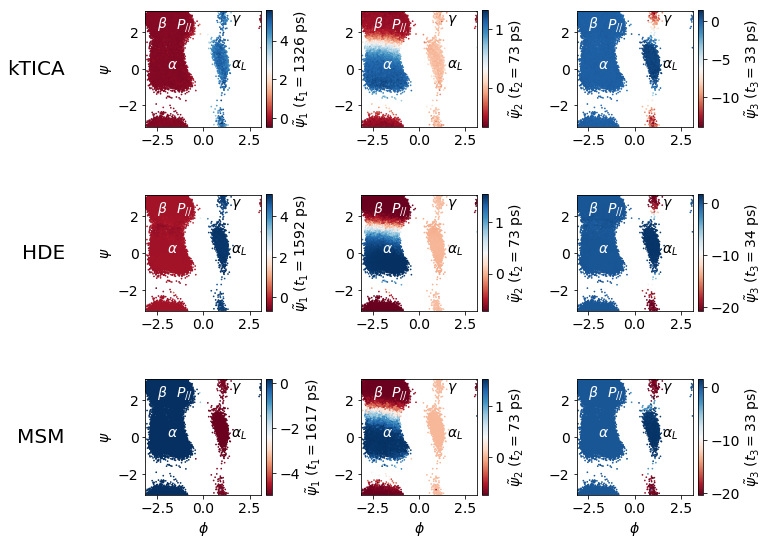

In [24]:
plt.rcParams['font.size'] = 14
def get_adp_state_plot(n_models):    
    skip = 10
    fig, axes = plt.subplots(n_models, 3)
    fig.set_size_inches(10, 3 * n_models + 1)

    coords_list = [ktica_coords, hde_coords, msm_coords][:n_models]
    timescales_list = [ktica_timescales, hde_timescales, msm_timescales][:n_models]
    for index_row in range(n_models):
        for item in range(3):
            temp_coords = coords_list[index_row][::skip, item]
            temp_coords *= np.sign(np.sum(temp_coords))
            ax = axes[index_row, item]
            im = ax.scatter(dihedrals[::skip, 0], dihedrals[::skip, 1], s=0.5, 
                                    c=temp_coords, cmap=plt.cm.RdBu)
            fig.colorbar(im, ax=ax, label='$\\tilde{\psi}_%d\ (t_%d = %d$ ps)' % (
                item + 1, item+1, timescales_list[index_row][item] * 2), fraction=0.046, pad=0.04)
            ax.text(-2, 0, '$\\alpha$', color='white')
            ax.text(-2.5, 2.2, '$\\beta$', color='white')
            ax.text(-1.5, 2.2, '$P_{//}$', color='white')
            ax.text(1.5, 0, '$\\alpha_L$')
            ax.text(1.5, 2.5, '$\\gamma$')
            ax.axis('square')
            ax.set_xlim([-np.pi, np.pi])
            ax.set_ylim([-np.pi, np.pi])
            if index_row == n_models - 1: ax.set_xlabel('$\phi$')
            if item == 0: ax.set_ylabel('$\psi$')

    row_label_list = ['kTICA', 'HDE', 'MSM'][:n_models]
    pad = 30 
    for ax, row in zip(axes[:, 0], row_label_list):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', va='center', fontsize=20)
    plt.subplots_adjust(wspace=0.7, hspace=0.05)
    return fig

fig = get_adp_state_plot(3)